In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
exact_column = "exact_data_based"
eps = 0.000001

import utils
input = utils.load_data([
    "../results/synthetic/1000/set4_aggregated/",
], "_x80_*")

data = utils.merge_exact(input, "exact_data_based")


# plot PNS of less EMCC agains bounds of 80 runs

In [49]:
for n in range(80):
    cols = [f"pns_{i}" for i in range(n+1)]
    a = data[cols].min(axis=1)
    b = data[cols].max(axis=1)
    l = data.pns_l_x
    u = data.pns_u_x

    data[f'error_r_{n}'] = np.sqrt(((l - a) ** 2 + (u - b) ** 2) / 2) / (u - l)


In [169]:
ns = [20, 40, 60,70]

nsname=str.join("-", np.array(ns).astype(str))
err_cols = [f'error_r_{i}' for i in ns]

In [170]:
dta = pd.melt(data[err_cols + ["treewidth"]], id_vars="treewidth")
dta["n"]=dta.variable.str.split("_").str[-1].astype(int)
sns.boxplot(x="treewidth", hue="n", y="value", data=dta, hue_order=ns)
plt.title("PNS EMCC Runs diff vs full by treewidth")
plt.tight_layout()
plt.savefig(f"PNS_runs_all_{nsname}.png")
plt.close()

dta[['treewidth','n','value']].to_csv(f"PNS_runs_all_{nsname}.csv")


And separate plots by markovianity

In [168]:
for n in [20,40,60,71, 80]:
    dt = data[data.error_r_60==max(data.error_r_60)][[f"pns_{i}" for i in range(n)]]
    print(n, [dt.min(axis=1).values, dt.max(axis=1).values])

20 [array([0.00277962]), array([0.02462414])]
40 [array([0.00206757]), array([0.0266687])]
60 [array([0.00113056]), array([0.0266687])]
71 [array([0.00106402]), array([0.0266687])]
80 [array([0.00106402]), array([0.22890834])]


In [150]:
def min_max(data, n):
    xx = data[np.abs(data.error_r_10-0.4092) < 0.001][[f"pns_{i}" for i in range(n)]]
    return [xx.min(axis=1).values, xx.max(axis=1).values]

In [156]:
print(min_max(data, 80))
for i in [10, 20, 30, 40, 50, 60, 70]:
    print(i, min_max(data, i))


[array([3.14985598e-05]), array([0.41225587])]
10 [array([0.00135012]), array([0.17365389])]
20 [array([0.00077774]), array([0.17365389])]
30 [array([0.00077774]), array([0.17365389])]
40 [array([0.00011213]), array([0.18321245])]
50 [array([0.00011213]), array([0.41225587])]
60 [array([0.00011213]), array([0.41225587])]
70 [array([3.14985598e-05]), array([0.41225587])]


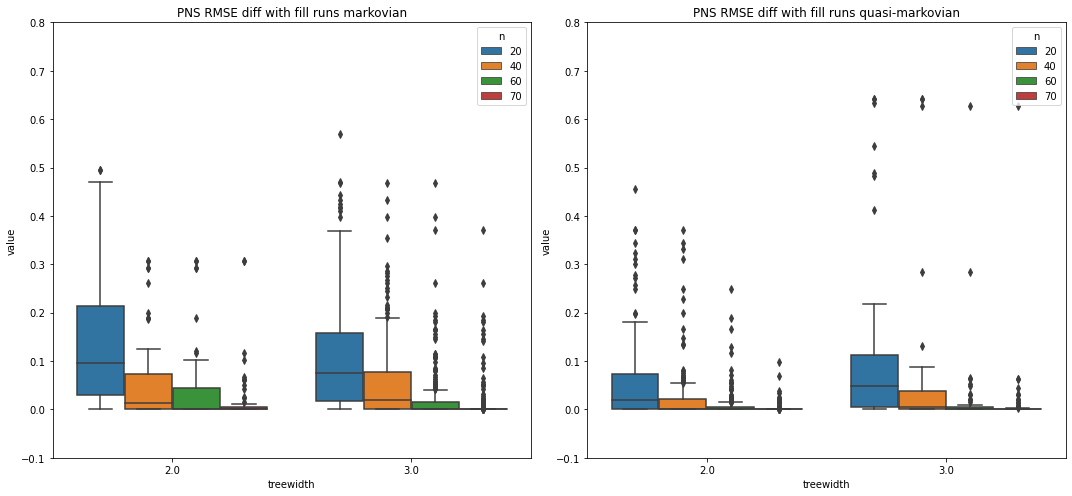

In [171]:
fig, ax = plt.subplots(1,2, figsize=(15,7))
i = 0
for mark in data.markovianity.unique():
    dta = pd.melt(data[data.markovianity==mark][err_cols + ["treewidth"]], id_vars="treewidth")
    dta["n"]=dta.variable.str.split("_").str[-1].astype(int)
    p = sns.boxplot(ax=ax[i], x="treewidth", hue="n", y="value", data=dta, hue_order=ns)
    #p = sns.boxplot(ax=ax[i], x="treewidth", hue="variable", y="value", data=dta, hue_order=err_cols)
    p.set_title(f"PNS RMSE diff with fill runs {mark}")
    p.set(ylim=(-0.1,0.8))
    dta.to_csv(f"PNS_runs_all_markovianity_{mark}_{nsname}.csv")
    i += 1

plt.tight_layout()

fig.savefig(f"PNS_runs_all_markovianity_{nsname}.png")




# now by the range of the interval

In [126]:
data["range"]=pd.cut(data.pns_u_x - data.pns_l_x, bins=3)

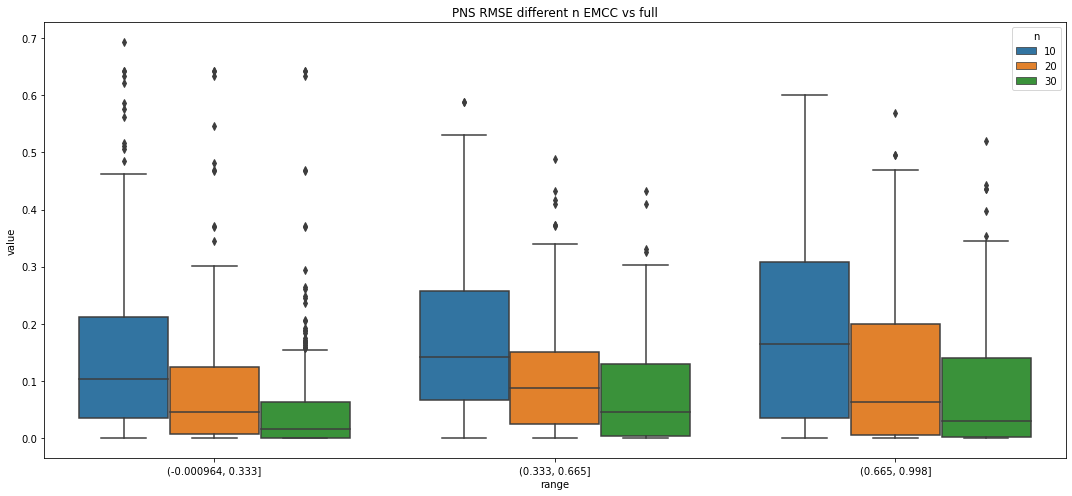

In [130]:
plt.figure(figsize=(15,7))
dta = pd.melt(data[err_cols + ["range"]], id_vars="range")
dta["n"] = dta.variable.str.split("_").str[-1].astype(int)
a = sns.boxplot(x="range", hue="n", y="value", data=dta, hue_order=ns)
a.set(title="PNS RMSE different n EMCC vs full")
dta['range'] = dta.range.astype(str)
dta[["n", "range", "value"]].to_csv(f"PNS_runs_all_by_range_{nsname}.csv")
plt.tight_layout()
plt.savefig(f"PNS_runs_all_by_range_{nsname}.png")

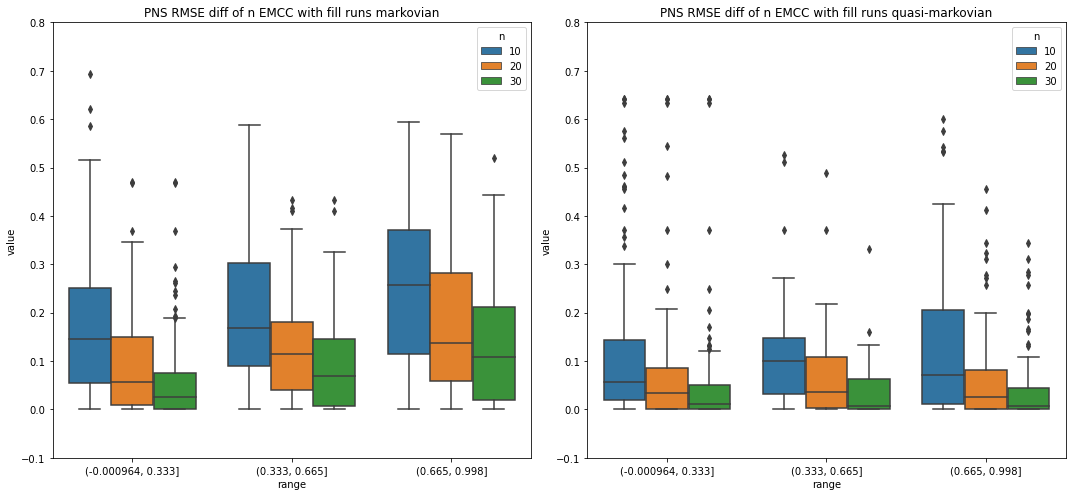

In [134]:
fig, ax = plt.subplots(1,2, figsize=(15,7))
i = 0
for mark in data.markovianity.unique():
    dta = pd.melt(data[data.markovianity==mark][err_cols + ["range"]], id_vars="range")
    dta["n"] = dta.variable.str.split("_").str[-1].astype(int)
    p = sns.boxplot(x="range", hue="n", y="value", data=dta, hue_order=ns, ax=ax[i])

    #p = sns.boxplot(ax=ax[i], x="range", hue="variable", y="value", data=dta, hue_order=err_cols)
    p.set_title(f"PNS RMSE diff of n EMCC with fill runs {mark}")
    p.set(ylim=(-0.1,0.8))
    i += 1
    dta['range']=dta.range.astype(str)
    dta[["n","range","value"]].to_csv(f"PNS_runs_all_by_range_markovianity_{mark}_{nsname}.csv")
plt.tight_layout()
plt.savefig(f"PNS_runs_all_by_range_markovianity_{nsname}.png")